In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import T5ForConditionalGeneration, T5Tokenizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.metrics import edit_distance
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 1. Dataset Class
class TypoDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = str(self.labels.iloc[idx])

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_tensors='pt'
        )

        targets = self.tokenizer.encode_plus(
            label,
            None,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'labels': targets['input_ids'].flatten()
        }

In [3]:
# 2. Training Functions
def train_epoch(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc='Training')
    
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        progress_bar.set_postfix({'loss': loss.item()})
    
    return total_loss / len(train_loader)

def validate(model, val_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_loss += loss.item()
    
    return total_loss / len(val_loader)


In [4]:
# 1. Fungsi untuk menyimpan model dan tokenizer
def save_model_and_tokenizer(model, tokenizer, output_dir):
    # Buat direktori jika belum ada
    os.makedirs(output_dir, exist_ok=True)
    
    # Simpan model dan tokenizer
    model.save_pretrained(output_dir)
    tokenizer.save_pretrained(output_dir)
    print(f"Model dan tokenizer disimpan di: {output_dir}")

# 2. Class untuk koreksi typo
class TypoCorrector:
    def __init__(self, model_dir):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
        print("Loading tokenizer dan model...")
        self.tokenizer = T5Tokenizer.from_pretrained(model_dir)
        self.model = T5ForConditionalGeneration.from_pretrained(model_dir).to(self.device)
        self.model.eval()
        
        print("Model siap digunakan!")

    def correct_text(self, text):
        inputs = self.tokenizer.encode_plus(
            text,
            return_tensors='pt',
            max_length=128,
            padding='max_length',
            truncation=True
        ).to(self.device)
        
        with torch.no_grad():
            outputs = self.model.generate(
                input_ids=inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                max_length=128,
                num_beams=4,
                early_stopping=True
            )
        
        corrected_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return corrected_text

In [5]:
# 3. Evaluation Class
class TypoModelEvaluator:
    def __init__(self, model, tokenizer, device):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.model.eval()
        
    def correct_text(self, text):
        inputs = self.tokenizer.encode_plus(
            text,
            return_tensors='pt',
            max_length=128,
            padding='max_length',
            truncation=True
        ).to(self.device)
        
        with torch.no_grad():
            outputs = self.model.generate(
                input_ids=inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                max_length=128,
                num_beams=4,
                early_stopping=True
            )
        
        return self.tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    def calculate_metrics(self, original_texts, corrected_texts, true_texts):
        bleu_scores = []
        edit_distances = []
        exact_matches = []
        char_accuracies = []
        
        smooth = SmoothingFunction().method1
        
        for orig, pred, true in zip(original_texts, corrected_texts, true_texts):
            # BLEU Score
            bleu = sentence_bleu([true.split()], pred.split(), smoothing_function=smooth)
            bleu_scores.append(bleu)
            
            # Edit Distance
            dist = edit_distance(pred, true)
            edit_distances.append(dist)
            
            # Exact Match
            exact_match = 1 if pred == true else 0
            exact_matches.append(exact_match)
            
            # Character-level Accuracy
            char_acc = sum(c1 == c2 for c1, c2 in zip(pred, true)) / max(len(pred), len(true))
            char_accuracies.append(char_acc)
        
        return {
            'bleu': np.mean(bleu_scores),
            'edit_distance': np.mean(edit_distances),
            'exact_match': np.mean(exact_matches),
            'char_accuracy': np.mean(char_accuracies)
        }
    
    def evaluate_dataset(self, test_loader):
        original_texts = []
        corrected_texts = []
        true_texts = []
        
        for batch in tqdm(test_loader, desc="Evaluating"):
            input_texts = [self.tokenizer.decode(ids, skip_special_tokens=True) 
                          for ids in batch['input_ids']]
            true_corrections = [self.tokenizer.decode(ids, skip_special_tokens=True) 
                               for ids in batch['labels']]
            
            model_corrections = [self.correct_text(text) for text in input_texts]
            
            original_texts.extend(input_texts)
            corrected_texts.extend(model_corrections)
            true_texts.extend(true_corrections)
        
        metrics = self.calculate_metrics(original_texts, corrected_texts, true_texts)
        return metrics, original_texts, corrected_texts, true_texts
    
    def plot_evaluation_results(self, metrics):
        plt.figure(figsize=(10, 6))
        plt.bar(metrics.keys(), metrics.values())
        plt.title('Evaluation Metrics')
        plt.ylim(0, 1)
        plt.show()
    
    def plot_error_distribution(self, original_texts, true_texts):
        error_lengths = [abs(len(orig) - len(true)) for orig, true in zip(original_texts, true_texts)]
        
        plt.figure(figsize=(10, 6))
        plt.hist(error_lengths, bins=20)
        plt.title('Distribution of Error Lengths')
        plt.xlabel('Absolute Difference in Text Length')
        plt.ylabel('Frequency')
        plt.show()
    
    def show_example_corrections(self, original_texts, corrected_texts, true_texts, n=5):
        indices = np.random.choice(len(original_texts), n, replace=False)
        
        for idx in indices:
            print(f"Original:  {original_texts[idx]}")
            print(f"Predicted: {corrected_texts[idx]}")
            print(f"True:      {true_texts[idx]}")
            print()


In [6]:
def train_and_evaluate_typo_model(df, num_epochs=5, batch_size=8, learning_rate=2e-5, patience=3):
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Split data
    train_texts, temp_texts, train_labels, temp_labels = train_test_split(
        df['kalimat_salah'], df['kalimat_awal'], test_size=0.2, random_state=42
    )
    val_texts, test_texts, val_labels, test_labels = train_test_split(
        temp_texts, temp_labels, test_size=0.5, random_state=42
    )

    # Initialize tokenizer and model
    tokenizer = T5Tokenizer.from_pretrained('t5-base')
    model = T5ForConditionalGeneration.from_pretrained('t5-base').to(device)

    # Create datasets
    train_dataset = TypoDataset(train_texts, train_labels, tokenizer)
    val_dataset = TypoDataset(val_texts, val_labels, tokenizer)
    test_dataset = TypoDataset(test_texts, test_labels, tokenizer)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Initialize optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

    # Training loop
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_no_improve = 0  # Counter for early stopping

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        train_loss = train_epoch(model, train_loader, optimizer, device)
        val_loss = validate(model, val_loader, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f'Training Loss: {train_loss:.4f}')
        print(f'Validation Loss: {val_loss:.4f}')

        # Check for improvement
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_typo_model.pt')
            print("Saved best model!")
            epochs_no_improve = 0  # Reset counter
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epoch(s).")

        # Early stopping condition
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Evaluation
    evaluator = TypoModelEvaluator(model, tokenizer, device)
    metrics, original_texts, corrected_texts, true_texts = evaluator.evaluate_dataset(test_loader)

    print("\nTest Set Evaluation Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    evaluator.plot_evaluation_results(metrics)
    evaluator.plot_error_distribution(original_texts, true_texts)

    print("\nExample Corrections:")
    evaluator.show_example_corrections(original_texts, corrected_texts, true_texts)

    return model, tokenizer, metrics

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86000 entries, 0 to 85999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   kalimat_awal   86000 non-null  object
 1   kalimat_salah  86000 non-null  object
dtypes: object(2)
memory usage: 1.3+ MB
None

Sample Data:
                                        kalimat_awal  \
0                                          bunyi apa   
1                                  siap siap belajar   
2  diskusikan gambar sampul di atas dengan menjaw...   
3          apa yang kalian lihat pada gambar di atas   
4                   menurut kalian apa isi ceritanya   

                                       kalimat_salah  
0                                           buni apa  
1                                   sia siap belajar  
2  diskusikan gambar sampul di atas dengan menawa...  
3           apa yang kalian lihat pada gambar d atas  
4                    menurut kalian

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Epoch 1/6


Validating: 100%|██████████| 1075/1075 [03:23<00:00,  5.30it/s]


Training Loss: 0.0413
Validation Loss: 0.0147
Saved best model!
Epoch 2/6


Validating: 100%|██████████| 1075/1075 [03:22<00:00,  5.32it/s]


Training Loss: 0.0151
Validation Loss: 0.0096
Saved best model!
Epoch 3/6


Validating: 100%|██████████| 1075/1075 [03:23<00:00,  5.27it/s]


Training Loss: 0.0098
Validation Loss: 0.0076
Saved best model!
Epoch 4/6


Validating: 100%|██████████| 1075/1075 [03:22<00:00,  5.30it/s]


Training Loss: 0.0069
Validation Loss: 0.0065
Saved best model!
Epoch 5/6


Validating: 100%|██████████| 1075/1075 [03:21<00:00,  5.32it/s]


Training Loss: 0.0051
Validation Loss: 0.0062
Saved best model!
Epoch 6/6


Validating: 100%|██████████| 1075/1075 [03:22<00:00,  5.31it/s]


Training Loss: 0.0038
Validation Loss: 0.0056
Saved best model!


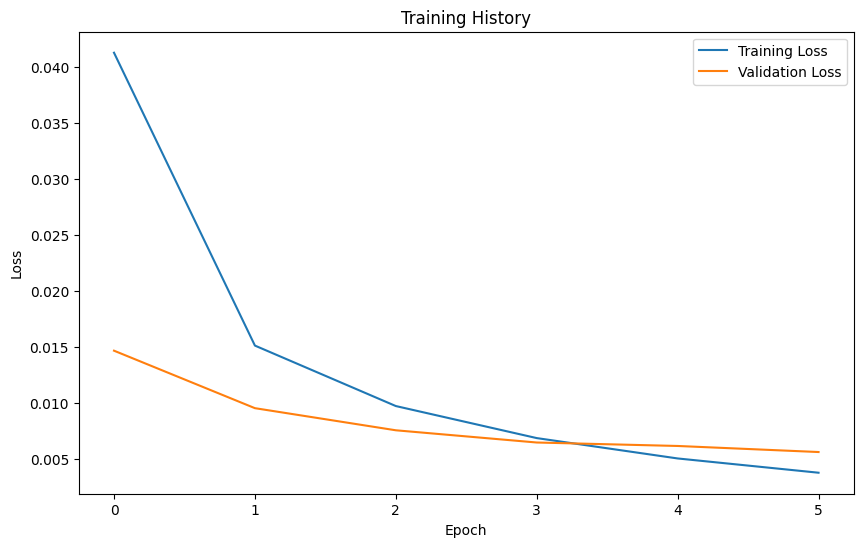

Evaluating: 100%|██████████| 1075/1075 [2:01:41<00:00,  6.79s/it] 



Test Set Evaluation Metrics:
bleu: 0.9380
edit_distance: 0.2533
exact_match: 0.8656
char_accuracy: 0.9638


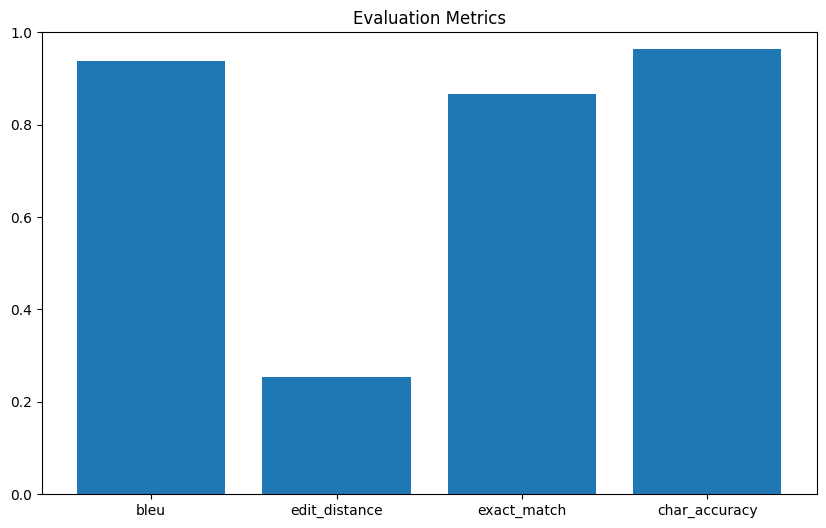

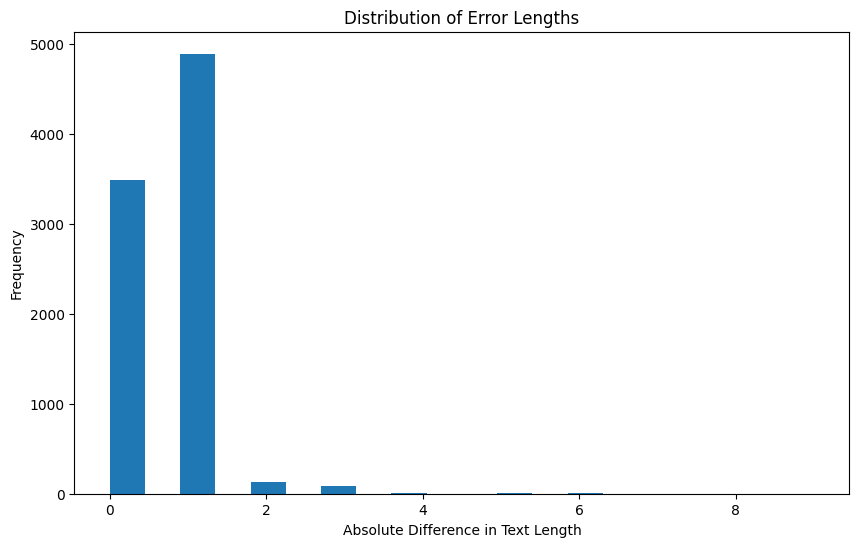


Example Corrections:
Original:  tanda baca atau pungtuasi menurut kbbi adalxh tanda grafis yang digunakan secara konvensional untuk memisahkan pelbagai bagian dari satuan bahasa tertulis
Predicted: tanda baca atau pungtuasi menurut kbbi adalah tanda grafis yang digunakan secara konvensional untuk memisahkan pelbagai bagian dari satuan bahasa tertulis
True:      tanda baca atau pungtuasi menurut kbbi adalah tanda grafis yang digunakan secara konvensional untuk memisahkan pelbagai bagian dari satuan bahasa tertulis

Original:  tempua bingung
Predicted: tempua bingung
True:      tempua bingung

Original:  sebuah naskah terdiri dari beberapa bit wang saling berkaitan
Predicted: sebuah naskah terdiri dari beberapa bit yang saling berkaitan
True:      sebuah naskah terdiri dari beberapa bit yang saling berkaitan

Original:  perhatikan ilustrasi di bawah ini untuk memahami teks prosedur dengan letih rinci
Predicted: perhatikan ilustrasi di bawah ini untuk memahami teks prosedur dengan lebih 

In [7]:
# 5. Usage
if __name__ == "__main__":
    # Load dataset 
    df = pd.read_csv("/kaggle/input/specilfull/combinedBI_Clean_86k.csv") 
    df.drop(columns=['tipe_kesalahan','kalimat_panjang'], inplace = True)
    
    # Print dataset info
    print("Dataset Info:")
    print(df.info())
    
    # Print sample data
    print("\nSample Data:")
    print(df.head())
    
    # Train and evaluate model
    model, tokenizer, metrics = train_and_evaluate_typo_model(
        df,
        num_epochs=6,
        batch_size=8,
        learning_rate=1e-4
    )
    
    # Save model and tokenizer
    model.save_pretrained('final_typo_model')
    tokenizer.save_pretrained('typo_tokenizer')
    print("\nModel and tokenizer saved successfully!")

In [8]:
import os
print("Working directory:", os.listdir('/kaggle/working'))
print("Input directory:", os.listdir('/kaggle/input'))

Working directory: ['final_typo_model', '.virtual_documents', 'typo_tokenizer', 'best_typo_model.pt']
Input directory: ['specilfull']


In [9]:
# 4. Simpan model
MODEL_DIR = '/kaggle/working/typo_correction_model'
save_model_and_tokenizer(model, tokenizer, MODEL_DIR)

Model dan tokenizer disimpan di: /kaggle/working/typo_correction_model


In [10]:
# 5. Inisialisasi corrector untuk inference
MODEL_DIR = '/kaggle/working/typo_correction_model'
#MODEL_DIR = '/kaggle/working/final_typo_model'
corrector = TypoCorrector(MODEL_DIR)

# Fungsi untuk melakukan koreksi
def correct_typo(text):
    original = text
    corrected = corrector.correct_text(text)
    return pd.DataFrame({'Original': [original], 'Corrected': [corrected]})

# 6. Fungsi koreksi interaktif
from ipywidgets import interact, widgets

@interact(text=widgets.Text(value='Ada sayu tradisi yang biasa dilakukan di sana, yakni upacara potong rambut.', description='Text:'))
def interactive_correction(text):
    result = correct_typo(text)
    display(result)

,Original,Corrected
0,"Ada sayu tradisi yang biasa dilakukan di sana,...","Ada satu tradisi yang biasa dilakukan di sana,..."


interactive(children=(Text(value='Ada sayu tradisi yang biasa dilakukan di sana, yakni upacara potong rambut.'…

In [11]:
import zipfile

MODEL_PATH = '/kaggle/working/best_typo_model.pt'
ZIP_PATH = '/kaggle/working/typo_correction_model.zip'

with zipfile.ZipFile(ZIP_PATH, 'w') as zipf:
    zipf.write(MODEL_PATH, arcname='model.pt')

In [13]:
import shutil

# Download file model
shutil.copy('/kaggle/working/best_typo_model.pt', 'best_typo_model_base.pt')

'best_typo_model_base.pt'

In [1]:
print('hello')

hello
